In [235]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [280]:
class Value:
    
    def __init__ (self, data, _children=(), _op="", label=""):
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self.data = data
        self._op = _op
        self.label=label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return self-other
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = _backward
        
        return result
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
            
        result._backward = _backward
            
        return result
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        result = Value(self.data**other, (self, ), f'**{other}')
                       
        def _backward():
            self.grad += (other * (self.data**(other-1))) * result.grad
                        
        result._backward = _backward
        return result
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        result = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * result.grad
        result._backward = _backward
            
        return result
    
    def relu(self):
        
        x = max(0, self.data)
        result = Value(x, (self, ), 'relu')
        
        def _backward():
            self.grad += result.grad if x > 0 else 0
        result._backward = _backward
        
        return result
    
    def exp(self):
        x = self.data
        result = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += result.data * result.grad
        result._backward = _backward
                         
        return result
    
    def _softmax(self, denom):
        result = Value(math.exp(self.data) / denom, (self, ), 'softmax')
        
        def _backward():
            self.grad += result.data * (1-result.data)
        result._backward = _backward
        
        return result
        
        
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
                
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [275]:
class Neuron:
    
    def __init__(self, nin, _activation): #num inputs
        self.w = [Value(random.uniform(-1, 1), label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')
        self._activation = _activation
        
    def __call__(self, x):
        act = sum((wi * wx for wi, wx in zip(self.w, x)), self.b)
        result = act.tanh()
        return result.relu()
    
    def parameters(self):
        return [self.b] + self.w
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) ==1 else outputs
    
    
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]
    
class MLP:
    
    def __init__(self, _layers):
        assert all(isinstance(item, int) for item in _layers)
        self.layers = [Layer(_layers[i], _layers[i+1]) for i in range(len(_layers)-1)]
    
    def __call__(self, x):
        assert len(x) == len(self.layers)
        output = x
        
        for layer in self.layers:
            output = layer(output)
        
        return output
    
    def parameters(self):
        
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
            
    def step(self, learning_rate):
        
        for p in self.parameters():
            p.data += -p.grad * learning_rate
            
def softmax(values):
    
    denom = sum((math.exp(n.data)) for n in values)
    return [n._softmax(denom) for n in values]


In [239]:
def RMSE(ypred, ytrue):
    return sum((yp-yt)**2 for yp, yt in zip(ypred, ytrue))
        

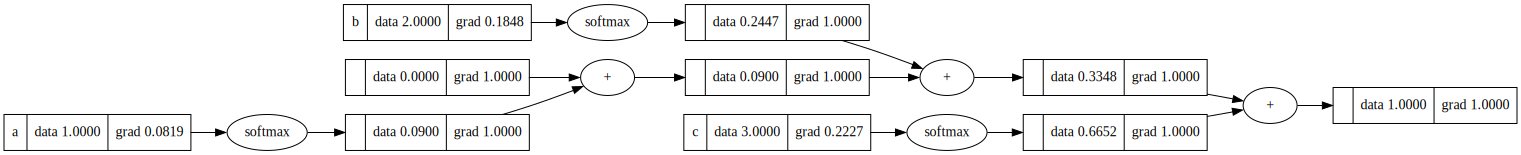

In [282]:
pord = [Value(1.0, label='a'), Value(2.0, label='b'), Value(3.0, label='c')]
pord = softmax(pord)
summary = sum(pord)

summary.backward()
draw_dot(summary)
    

In [263]:
model = MLP([3, 4, 4, 1])

xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1, -1, -1, 1]

for i in range(500):
    model.zero_grad()
    ypred = [model(x) for x in xs]
    loss = RMSE(ys, ypred)
    loss.backward()
    model.step(.05)
    print(loss)



Value(4.855571344437921)
Value(1.2530513542095902)
Value(0.41514398501823346)
Value(0.2633506010997573)
Value(0.19054947339403994)
Value(0.14779264597660197)
Value(0.11984794739612387)
Value(0.10027310497162809)
Value(0.085866998789101)
Value(0.07486278917954185)
Value(0.06620859660775852)
Value(0.05924094674952074)
Value(0.05352173663209654)
Value(0.04875067455355128)
Value(0.04471543228028421)
Value(0.04126187652353997)
Value(0.038275564639408656)
Value(0.03566984286394109)
Value(0.03337796235620201)
Value(0.031347720705906836)
Value(0.02953773649968098)
Value(0.027914806633791665)
Value(0.026451997664422952)
Value(0.025127244814518338)
Value(0.02392230844093309)
Value(0.0228219863365563)
Value(0.02181351187026015)
Value(0.02088608896286046)
Value(0.020030529081126226)
Value(0.019238965169538727)
Value(0.018504624224458838)
Value(0.0178216450080542)
Value(0.01718493082792774)
Value(0.01659002979017412)
Value(0.016033036749847452)
Value(0.01551051252571501)
Value(0.015019416948632281)

Value(0.0011071196523637548)
Value(0.001103974050399026)
Value(0.0011008457605660251)
Value(0.001097734642028252)
Value(0.0010946405554626527)
Value(0.0010915633630394933)
Value(0.0010885029284024243)
Value(0.0010854591166489585)
Value(0.0010824317943112522)
Value(0.001079420829337115)
Value(0.0010764260910713982)
Value(0.0010734474502376674)
Value(0.0010704847789200817)
Value(0.0010675379505456627)
Value(0.0010646068398667983)
Value(0.0010616913229439682)
Value(0.001058791277128823)
Value(0.001055906581047479)
Value(0.0010530371145840464)
Value(0.0010501827588644925)
Value(0.0010473433962406723)
Value(0.0010445189102745898)
Value(0.0010417091857230403)
Value(0.0010389141085223059)
Value(0.0010361335657732096)
Value(0.0010333674457263253)
Value(0.0010306156377674677)
Value(0.0010278780324033613)
Value(0.0010251545212475335)
Value(0.001022444997006424)
Value(0.001019749353465714)
Value(0.0010170674854768113)
Value(0.0010143992889436267)
Value(0.0010117446608094536)
Value(0.0010091034990

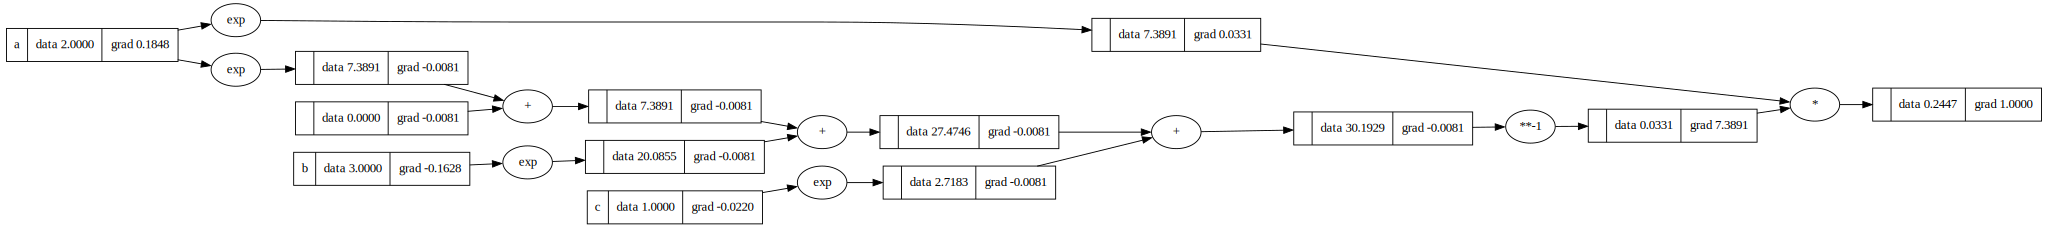

In [258]:
fort = [Value(2.0, label='a'), Value(3.0, label='b'), Value(1.0, label='c')]

summ = sum((bob.exp() for bob in fort))
for i, fo in enumerate(fort):
    fort[i] = fo.exp() / summ

fort[0].backward()
draw_dot(fort[0])

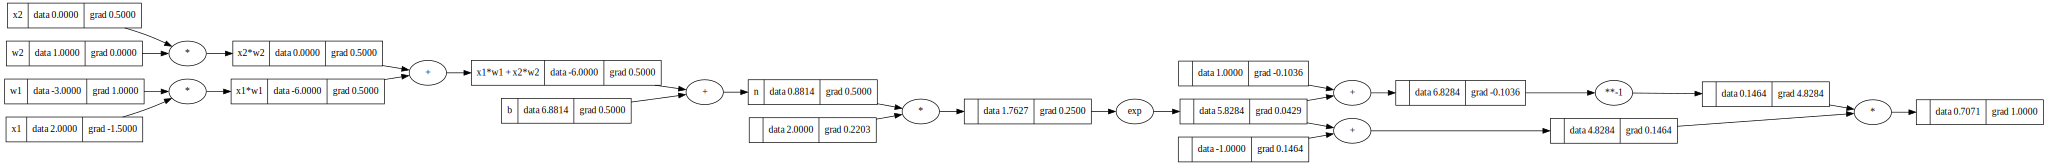

In [190]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)


o.backward()
draw_dot(o)

